# Comic Book Cancellations Part II: Machine Learning

This series looks to determine what is the primary factors that determine whether a Marel comic book gets cancelled. When a string of cancellations in 2017 only targeted books with diverse leads, it is worth revisiting whether books are cancelled solely because their low sales.

Not all titles that end though are actually cancellations. Titles that only run a few issues may only have been intended to be a mini-series and longer running titles often restart with a new #1 issue to signify a change in the creative team. However, for ongoing titles, the 12th issue is a common cancellation issue. So I'm gonig to specifically determine what threshold causes a book to be cancelled or kept at that 12th month deciding point.

In the [first part](./1 Comic Book Cancellations - Web Scrapping.ipynb) of this series, Marvel comic book sales information from 1998 and after were scrapped from [Comichron](http://www.comichron.com/monthlycomicssales.html) and cleaned up and stored into a database file. In this section, we will use machine learning on that database to determine the cancellation criteria.

# 1 Getting Started

## Imports

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import neighbors, discriminant_analysis, svm, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from subprocess import check_call
from IPython.display import Image

%matplotlib inline

## Load Data

In [2]:
db = sqlite3.connect('sales.db')

# Load web scrapped data from SQL database for Marvel comics
df = pd.read_sql_query('''
SELECT *
FROM marvel_sales
''', db,index_col='index')
db.close()

## Plot Classification 2D

plotClassification2D displays a 2D plot over *features* of predicted class *c* based on the classifier *clf* for the table *df*.

In [3]:
def plotClassification2D(df, features, c_names, clf):
    c = c_names[0]
    X = df[features]
    y = df[c]
    clf.fit(X, y)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    h = 1000
    [xmin, xmax] = [0, 0.7*np.max(X.iloc[:,0])]
    [ymin, ymax] = [0, 0.7*np.max(X.iloc[:,1])]

    grid = np.mgrid[xmin:xmax:h, ymin:ymax:h]
    [xx, yy] = grid
    Z = clf.predict(grid.reshape(2,-1).T)

    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(x=df.loc[df[c]==1,features[0]], y=df.loc[df[c]==1,features[1]], c='blue', edgecolor='k', s=20, label=c_names[0])
    plt.scatter(x=df.loc[df[c]==0,features[0]], y=df.loc[df[c]==0,features[1]], c='red', edgecolor='k', s=20, label=c_names[1])

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(loc='best')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

# 2 Preliminary Analysis

## Fatures

Each row in our table corresponds to a different run of a series (with a specific title and starting year). Whereas the columns contain features that include the units and gross sales for each issue for the first 12 months. It also contains exponential fit parameters for both the units and the gross sales. For units, the exponential fit parameters are *UI* for the intial sales, *UT* which is the time constant, and *UF* for the final asymptotic sales. There are also corresponding gross sales parameters *GI*, *GT*, and *GF*.

In [50]:
print('Columns: ' + ' '.join(df.columns))

Columns: Title StartYear Units1 Units2 Units3 Units4 Units5 Units6 Units7 Units8 Units9 Units10 Units11 Units12 Gross1 Gross2 Gross3 Gross4 Gross5 Gross6 Gross7 Gross8 Gross9 Gross10 Gross11 Gross12 MaxIssue CurrentTitle Kept UI UT UF GI GT GF


## Null Accuracy 

Our data set include 288 different series and about 74% of new titles last longer than 12 months. 

A poor classifier that returns that all series should be kept would therefore be accurate about 74% of the time. Such a naive classifier would not be helpful in determining a cancellation criteria, but it does set a minimum threshold of how accurate our trained models should be.

Because our data is so skewed with so many more "Kept" titles than "Cancelled" titles, accuracy may not be the best means of scoring a classifier. Other scoring criteria such as the F1-Score or AUC focus more on maximizing parameters such as precision and sensitivity and are insensitive to a high class inbalance. However, for our problem, I will continue to use accuracy as our scorer. 

In [52]:
print('Kept Count: {}, Cancelled Count: {}, Total Count: {}\n'.format(len(df[df.Kept == True].index), len(df[df.Kept == False].index), len(df.index)))
print('Null Accuracy: {:.1%}'.format(df.Kept.mean()))

Kept Count: 213, Cancelled Count: 75, Total Count: 288

Null Accuracy: 74.0%


## Variable Correlations

As can be expected, the sales values from one month to the next are heavily correlated with each other. 

Looking at the unit sales for the first 12 months, we see that #1 issue sales are weakly correlated with sales from the remaining months. Otherwise, there is generally a stronger correlation of units sold between issues in the first half with each other than with issues in the second half and vice versa. 

Still, monthly sales (excluding the first issue) are generally well correlated with one another. This means that if our classifier considers one month's sales to be a strong indicator of cancellation than sales information for the other months should be almost as strong of an indicator. Even though I have many features with each month's sales information, I'm not gaining much additional information with each feature. 

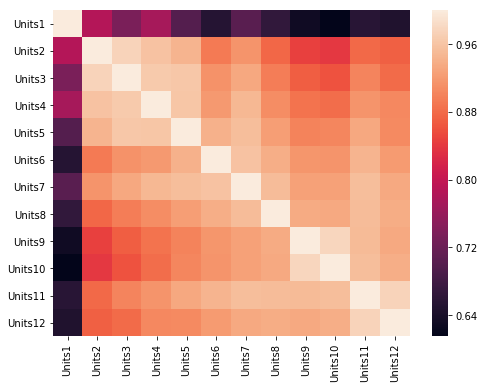

In [55]:
plt.figure(figsize=(8,6))
sns.heatmap(df.iloc[:,2:14].corr())

# 3 Decision Trees

One of the most important properties I'm looking for in my classification criteria is that it be easily understandable by people. Additionally, cancellation is decided by people so it shouldn't be a process that is decided by an overly complicated model. As such, it makes the most sense to use a decision tree as my first classifier.

## Validation Curve

Decision trees though have a tendency to over-fit the training data and not be generalizable. In oder to decrease the variance, I'll vary the minimum number of samples in each leaf of the tree. To determine the best property for that parameter, I'll create a validation curve to determine a training and test score as that parameter varies.

Because the testing data used in the validation curve is used to determine the minimum samples per leaf size, an additional testing data to score accuracy will need to be split off from the data first.

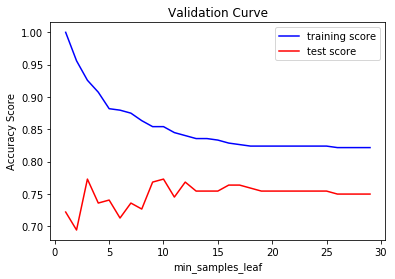

In [107]:
# Use all features except the obviuosly unimportant ones or the ones that include information about the classification
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'UI', 'GI', 'Kept', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

# Vary the minimum numbers of samples in each leaf of the decision tree and find optimal value. Increasing this amount decreases variance.
clf = GridSearchCV(tree.DecisionTreeClassifier(), {'min_samples_leaf':np.arange(1,30)}, return_train_score=True)

# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

plt.plot(clf.cv_results_['param_min_samples_leaf'], clf.cv_results_['mean_train_score'], color='blue', label='training score')
plt.plot(clf.cv_results_['param_min_samples_leaf'], clf.cv_results_['mean_test_score'], color='red', label='test score')
plt.legend(loc='best')
plt.title('Validation Curve')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy Score')
plt.show()

## Cross-Validation Accuracy

I'll use cross-validation to measure the accuracy of this technique. Cross-Validation splits the data into segments. It iteratively uses each segment as testing data while the rest of the data is used for training (and in this case determine the minimum samples per leaf). Cross-validation automatically nests these operations so that testing data is not used for determining the minimum samples per leaf. 

Because of the high class imbalance, the null accuracy for this data is around 74%. The accuracy score for the decision tree is similar with relatively high variance.

In [108]:
# Find the accuracy score from nested cross-validation and grid search
scores = cross_val_score(clf,X,y, cv=10)
print("Cross-Validation Score: {}\u00B1{:.0%}\n".format(int(100*scores.mean()), scores.std()))

Cross-Validation Score: 71±11%



## Accuracy Checking

For our purpose, it is not sufficient to only get a high accuracy score, rather the decision tree needs to be able to distinguish between the Kept and Cancelled titles.

To better see how well the classification worked, we can view the confusion matrix and calculate values like the true positive rate (recall).

We can see that because of the class imbalance, the classifier does much better at classifying titles that were "Kept" than those that were "Cancelled".

In [82]:
# Confusion matrix for the test data
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

# Classification report for the testing data set
print('\nClassification Report')
print(classification_report(y_act, y_pred)) 


Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,7,19,26
Kept,5,41,46
All,12,60,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.58      0.27      0.37        26
       Kept       0.68      0.89      0.77        46

avg / total       0.65      0.67      0.63        72



## Display Tree

The fitted decision tree can also be built to showcase the logic involved.

Because the data is split into testing and training sets randomly, each time the classifier is trained there will likely be changes in the resulting decision tree.

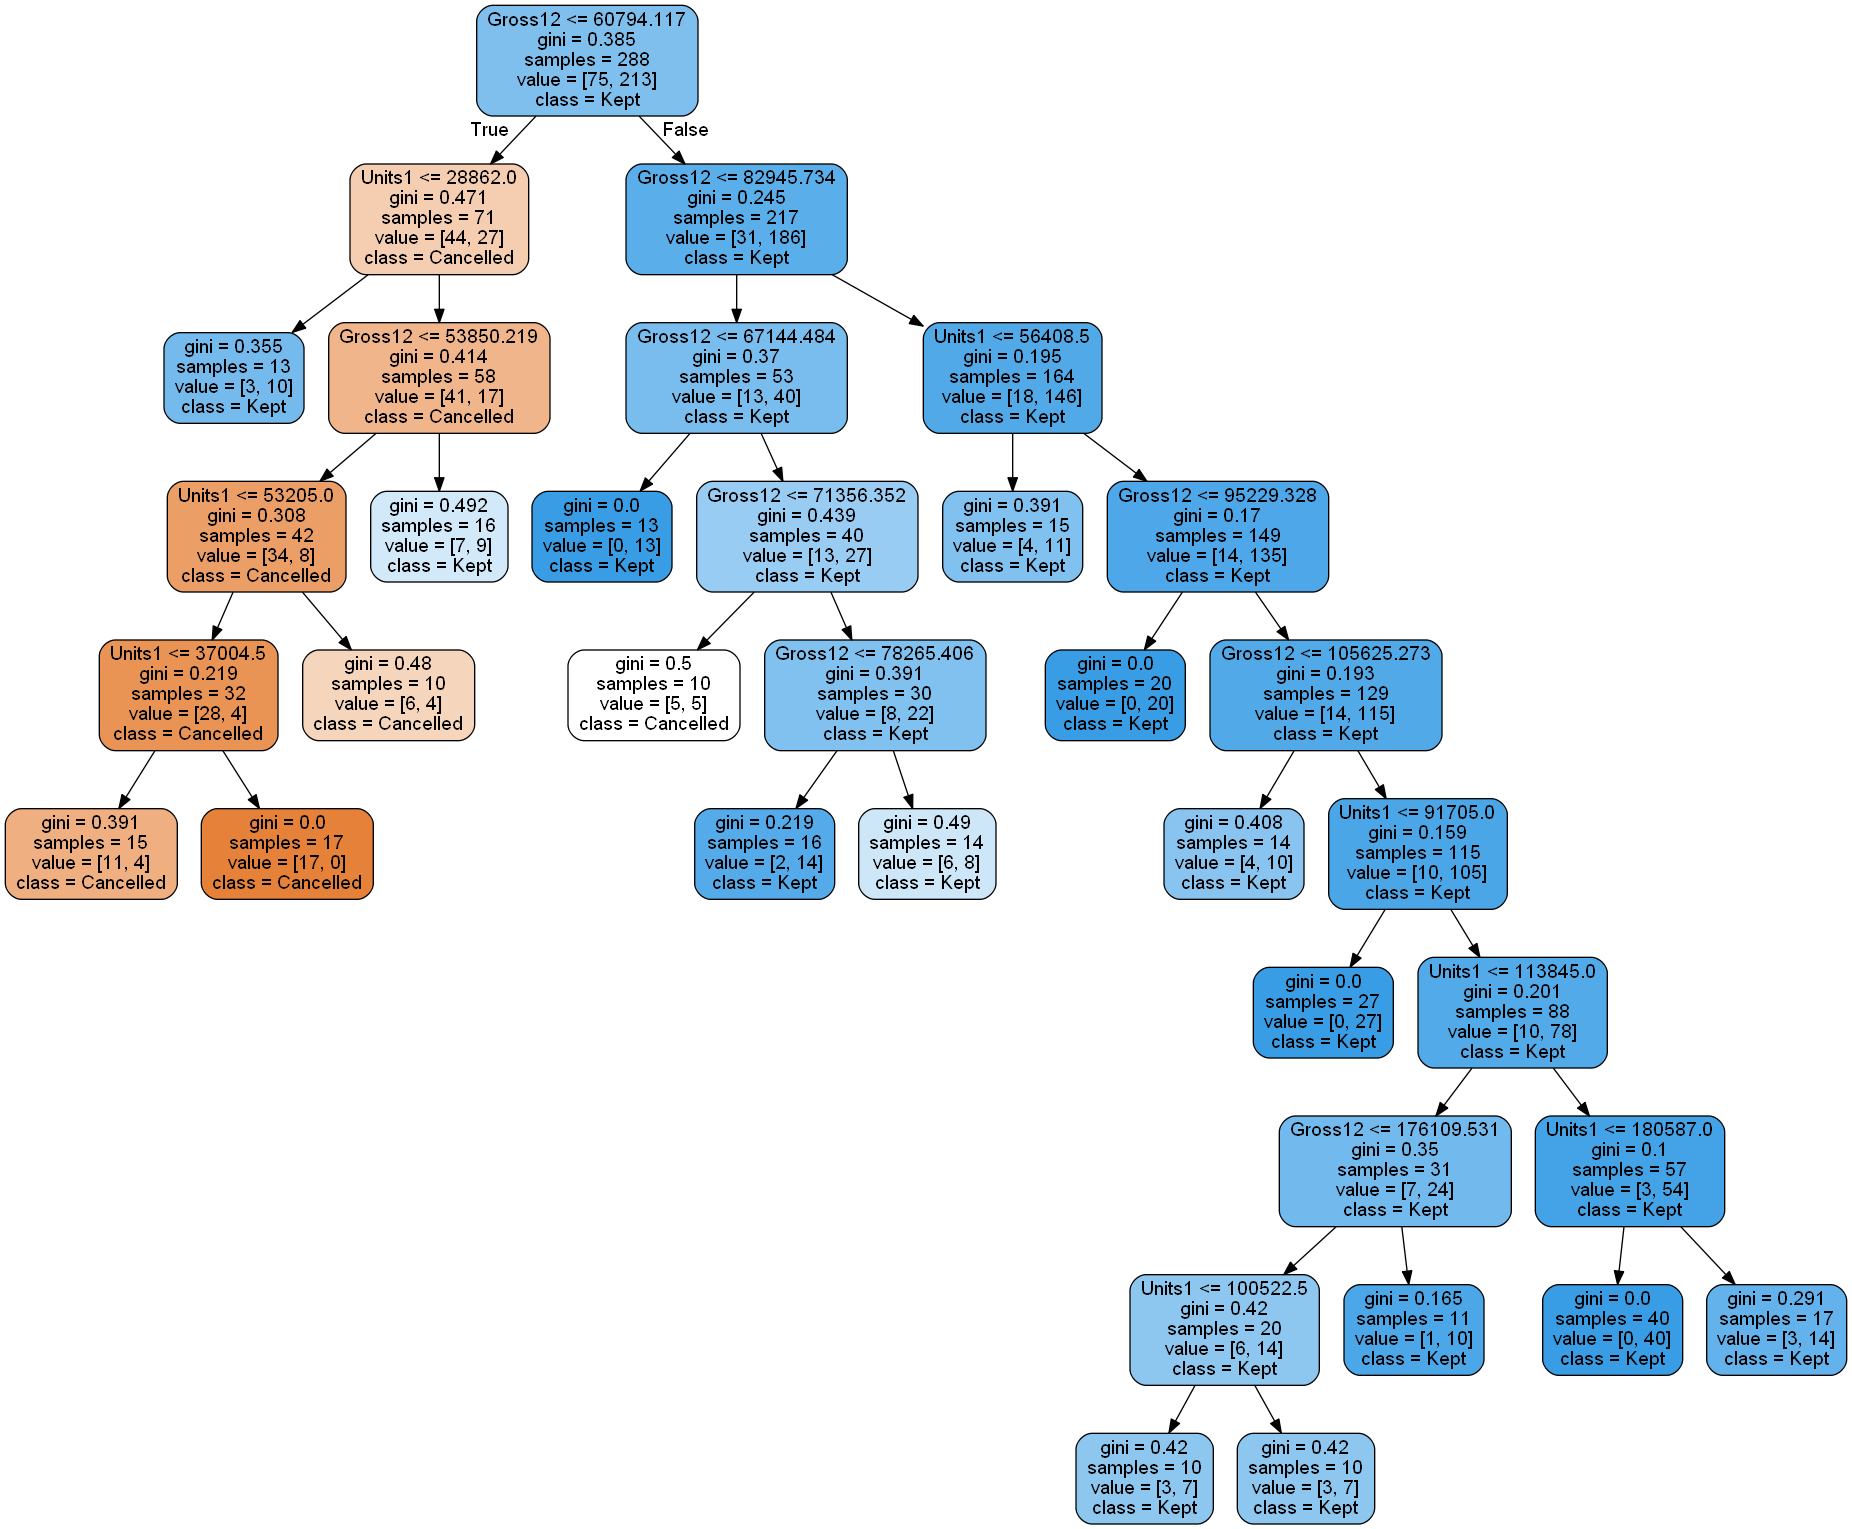

In [99]:
# Display the decision tree from the fit
dot_data = export_graphviz(clf.best_estimator_, out_file='tree.dot', feature_names=features, class_names=['Cancelled', 'Kept'], 
                           filled=True, rounded=True)
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
display(Image("tree.png"))

## Most Important Features

From the decision tree, we can list the features that are most important to the fit. 

In my case, the most important feature was the gross sales on the last month demonstrating that indeed diminishing sales is the number one reason why a title is cancelled.

In [103]:
# Show the most important features and use plotDataClassification on those features
features_importance = pd.DataFrame(clf.best_estimator_.feature_importances_, index=features, 
                                   columns=['Importance']).sort_values(by='Importance', ascending=False)
display(features_importance.head(3))

,Importance
Gross12,0.772462
Units1,0.227538


## Plotting Fit Most Important Features

A decision tree is fitted to the top two features and its predictions are plotted as the light colored background. A point for each tile is colored dpending on its classification. This can be a more convenient way of seeing the type of results generated by the decision tree. However, this plot shows all the data points and does not distinguish betwen testing and training sets so it should not be used to gauge the accuracy of the classifier.

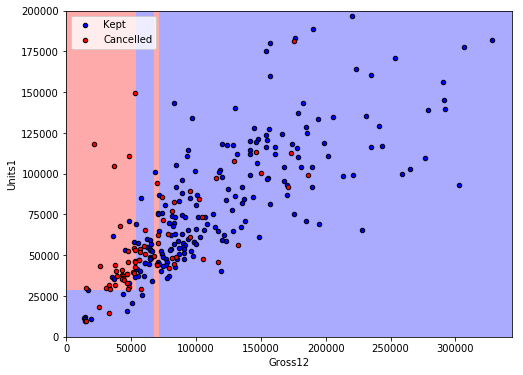

In [104]:
# Plot the fit to the the two most important features
features = features_importance.iloc[0:2].index.values
plt.figure(figsize=(8,6))
plotClassification2D(df, features, ['Kept', 'Cancelled'], clf.best_estimator_)
plt.ylim([0, 200000])
plt.show()

## Decision Tree Discussion

The decision trees calculated may vary slightly depending on the training and testing set extracted from the data. For my data, the most important feature was the gross sales in the 12th month followed by the units shipped for the first issue. The book was generally cancelled if it was grossing \$60,000 per issue or less. 

### Niche titles with low 1st and 12th month sales are kept

There were some exceptions, for example 75% of books selling less than \$60,000 but shipping less than 28,000 books in the first issue were kept. So that means there were some niche titles that had always sold few issues and made less money

In [130]:
print('Niche Titles: Low 1st and 12th Month Sales')
df.loc[(df.Gross12 < 60000) & (df.Units1 < 28000),['Title', 'StartYear', 'Kept']]

Niche Titles: Low 1st and 12th Month Sales


,Title,StartYear,Kept
index,,,
72,Civil War Chronicles,2007.0,0
73,Powers Bureau,2013.0,0
74,Super Hero Squad,2010.0,0
279,X-Men First Class Vol. 2,2007.0,1
280,Runaways,2003.0,1
281,Fury Max,2012.0,1
282,X-Men Forever 2,2010.0,1
283,Marvel Adventures Iron Man,2007.0,1
284,Marvel Adventures Hulk,2007.0,1


Looking at these titles, many of the titles that were kept are part of Marvel's children's line (Marvel Adventurse) or target teens (i.e. *Spider-Man Love Mary Jane* or *Runaways*). Our data looks at titles distributed through Diamond which would mainly be issues sold at comic book stores. Children and teen readers may be more likely to pick up and read collected editions which would explain why these series continued despite ongoing low sales. More data on collected edition sales would be needed to determine the validity of that statement.

### Even high selling comics sometimes get cancelled

Looking at our plot, we do see that a few high selling comics are cancelled. What distinguishes these comics? Let's pull out the titles that are selling more than twice the cancellation threshold.

In [118]:
df.loc[(df.Gross12 > 120000) & (df.Kept == 0),['Title', 'StartYear', 'Kept']]

,Title,StartYear,Kept
index,,,
0,Deadpool,2015.0,0
1,Amazing Spider-Man,2015.0,0
2,Spider-Man Deadpool,2016.0,0
5,Kanan,2015.0,0
6,Young Avengers,2005.0,0
8,Avengers Invaders,2008.0,0
10,Spider-Man Chapter 1,1998.0,0
11,Earth X,1999.0,0
14,Avengers Forever,1998.0,0


Nothing immediately stands out about theses titles except that they include some of Marvel's biggest brands. Some of the titles like Kanan [startled the comic book press](https://dorksideoftheforce.com/2015/12/17/marvels-kanan-comic-series-will-end-with-issue-12/) when it got cancelled despite having high sales. 

Because of some of these inconsistencies and missing information, there's no way the classifier would be able to classify all the titles correctly.

# 4. Random Forests

One problem with decision trees is that they greedily pick most the important features as they're built. This means that when maximizing the accuracy score, they might find a local maximum rather than a global mazimum. Similarly, they do not rank features globally by importance.

Random forests are an ensemble method that builds a large number of decision trees while randomly limiting what features can be used at each branch in the tree. Then all the trees are averaged together. This allow features other than the most important feature to have more influence in the classifier.

Just like with the decision trees, I'll first be developing a few validation curves as we vary parameters for both the minimum number of samples per leaf as well as the maximum number of features to consider for each split.

## Validation Curve

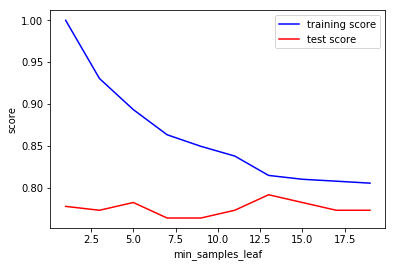

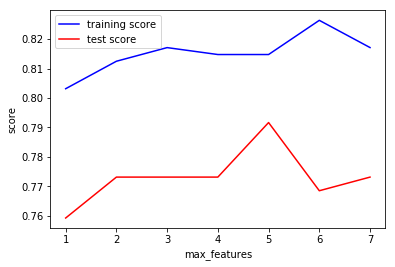

In [140]:
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'Kept', 'UI', 'GI', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

# Vary the parameters for the minimum number of samples per leaf and the maximum features to make each branch off of
params = {'min_samples_leaf' : np.arange(1,21,2), 'max_features' : np.arange(1,8)}
clf = GridSearchCV(RandomForestClassifier(n_estimators = 100), params, return_train_score=True)

# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

results = pd.DataFrame(clf.cv_results_)
params = list(params.keys())
for p in params:
    r = results.copy()
    not_p = params.copy()
    not_p.remove(p)
    for x in not_p:
        r = r[r['param_' + x] == clf.best_params_[x]]

    plt.plot(r['param_' + p], r['mean_train_score'], color='blue', label='training score')
    plt.plot(r['param_' + p], r['mean_test_score'], color='red', label='test score')
    plt.legend(loc='best')
    plt.xlabel(p)
    plt.ylabel('score')
    plt.show()

## Cross-Validation Accuracy Score

Similar to the decision trees, an cross-validated accuracy score will be calculated with the optimized parameters. The scoring step is nested so that separate testing data is used to determine the score from the testing data used to optimize the parameters.

The accuracy score is similar to what was achieved for both decision trees and the null accuracy score.

In [129]:
scores = cross_val_score(clf,X,y, cv=10)
print("Cross-Validation Score: {}\u00B1{:.0%}\n".format(int(100*scores.mean()), scores.std()))

Cross-Validation Score: 73±13%



## Confusion Matrix

Once again, to better understand the accuracy score, we can check the confusion matrix. 

Similar to the decision trees, "Kept" titles are much more likely to be accurately determined than "Cancelled" titles.

In [128]:
# Confusion matrix and Classification Report for all folds in a K-fold Cross-validation  
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

print('\nClassification Report')
print(classification_report(y_act, y_pred)) 


Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,7,10,17
Kept,4,51,55
All,11,61,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.64      0.41      0.50        17
       Kept       0.84      0.93      0.88        55

avg / total       0.79      0.81      0.79        72



## Important Features

Decision trees measure the most important feature greedily after each split. When measuring feature importance, that means features that are highly correlated with higher ranking features are not shown to be important.

Random forests shoudl be better able to determine each features importance even when they are highly correlated with other features (as in my case).

Once again, the final gross sales are the most important feature. However, we can also see that many of the other features are about equally important becuase of their strong correlation with one another. 

In [131]:
# Show the most important features and use plotDataClassification on those features
print('Most Important Features')
features_importance = pd.DataFrame(clf.best_estimator_.feature_importances_, index=features, 
                                   columns=['Importance']).sort_values(by='Importance', ascending=False)
display(features_importance.head(10))

Most Important Features


,Importance
GF,0.051234
Units12,0.049002
Units8,0.048783
Gross3,0.042388
UF,0.041597
Units7,0.040491
Gross8,0.040435
Gross4,0.039501
GT,0.039240
Gross10,0.039023


## 2D Plot

So we can plot the predictions from the random forest. This plot is only going to use the top two features used by the decision tree example above which means it'll be using fewer features than the rest of our random forest analysis. However, this will allow us to visualize both the similarities and differences between the random forest and the decision trees. For the most part, the results are incredibly similar.

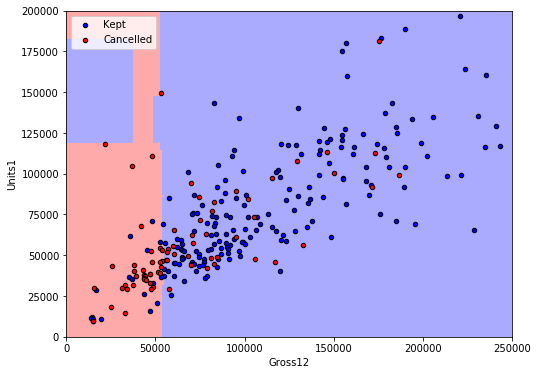

Cross-Validation Score: 67±23%



In [148]:
features = ['Gross12', 'Units1']
X = df[features]
y = df['Kept']

clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=12)
plt.figure(figsize=(8,6))
plotClassification2D(df, features, ['Kept', 'Cancelled'], clf)
plt.xlim([0, 250000])
plt.ylim([0, 200000])
plt.show()
scores = cross_val_score(clf, X, y, cv=10)
print("Cross-Validation Score: {}\u00B1{:.0%}\n".format(int(100*scores.mean()), scores.std()))

## Random Forest Discussion

Random forests are a more complicated classifier than decision trees, but we find that they are not providing any better of an accuracy score. Because of the increased difficulty of interpreting their results, we thus conclude that the decision trees are the better classifier.

However, the random forests do show that many of the features are similar in importance but that the final gross sales is indeed the most important feature. This should not be surprising considering that most of the features are heavily correlated with one another.

# 5 Other Classifiers

Many other classifiers are harder to interpret than the decision trees. However, I'll try a variety of other machine learning methods to determine whether any work significantly better for this data set.

## 5.1 K-Nearest Neighbors (KNN)

K-Nearest Neighbors is a simple classifiers the makes a prediction at each point based on the prediction of its *k* nearest neighbors. It's an extremely simple model to use but doesn't necessarily make clear lines distinguishing classes.

### Validation Curve

A key parameter for KNN is the number of neighbors to sum over. Let's plot the validation curve for that parameter.

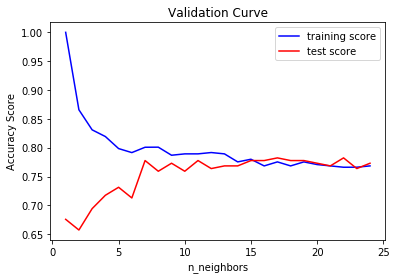

In [157]:
# Use all features except the obviuosly unimportant ones or the ones that include information about the classification
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'UI', 'GI', 'Kept', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

# Vary the parameter
clf = GridSearchCV(neighbors.KNeighborsClassifier(), {'n_neighbors':np.arange(1,25)}, return_train_score=True)

# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

plt.plot(clf.cv_results_['param_n_neighbors'], clf.cv_results_['mean_train_score'], color='blue', label='training score')
plt.plot(clf.cv_results_['param_n_neighbors'], clf.cv_results_['mean_test_score'], color='red', label='test score')
plt.legend(loc='best')
plt.title('Validation Curve')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy Score')
plt.show()

### Cross-Validation Accuracy

The accuracy is similar to the previous classifiers.

In [154]:
# Find the accuracy score from nested cross-validation and grid search
scores = cross_val_score(clf,X,y, cv=10)
print("Cross-Validation Score: {}\u00B1{:.0%}\n".format(int(100*scores.mean()), scores.std()))

Cross-Validation Score: 72±12%



### Confusion Matrix

It also has troubel correctly labelling the "cancelled" titles compared to the "kept" titles.

In [155]:
# Confusion matrix for the test data
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

# Classification report for the testing data set
print('\nClassification Report')
print(classification_report(y_act, y_pred)) 


Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,8,12,20
Kept,5,47,52
All,13,59,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.62      0.40      0.48        20
       Kept       0.80      0.90      0.85        52

avg / total       0.75      0.76      0.75        72



### KNN: Plot 2D

Using only the two features, we see that KNN almost makes a line that bisects the graph.

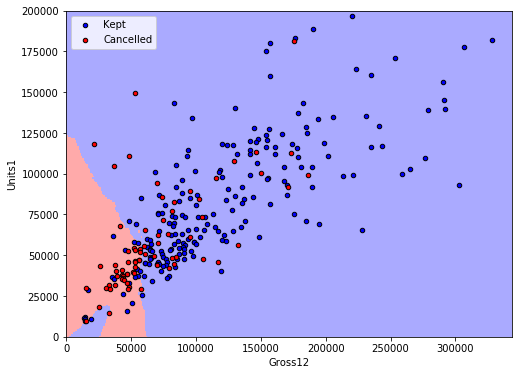

In [156]:
features = ['Gross12', 'Units1']
clf = neighbors.KNeighborsClassifier(n_neighbors = 10)

plt.figure(figsize=(8,6))
plotClassification2D(df, features, ['Kept', 'Cancelled'], clf.best_estimator_)
plt.ylim([0, 200000])
plt.show()

### KNN Discussion

The accuracy and results for KNN don't provide any advantages over what we were able to do over decision trees.

## 5.2 Support Vector Machines (SVM)

Seeing that the KNN classifier almost made a line that bisects the data, I'm going to try the Support Vector Machine classifier next. Support Vector Machines will fit a multidimensional line that splits the data set by maximizing the separation between the line and the training points closest to the line.

### Accuracy Score

The SVM classifier is more computationally expensive than the other classifiers if I use all the features. Using just the main features found from the decision tree classifier, I find that the accuracy is similar to if not slightly better than the decision tree. 

In [4]:
# Use all features except the obviuosly unimportant ones or the ones that include information about the classification
features = ['Gross12', 'Units1']
X = df[features]
y = df['Kept']

# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the training data and find accuracy from test data
clf = svm.SVC(kernel='linear', C=100)
clf.fit(X_train, y_train)
print("Accuracy Score: {:.1%}".format(accuracy_score(y_test, clf.predict(X_test))))

Accuracy Score: 76.4%


### Confusion Matrix

The confusion matrix though shows that the classifier barely manages to classify any of the "Cancelled" data sets. 

In [5]:
# Confusion matrix for the test data
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

# Classification report for the testing data set
print('\nClassification Report')
print(classification_report(y_act, y_pred)) 


Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,1,15,16
Kept,2,54,56
All,3,69,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.33      0.06      0.11        16
       Kept       0.78      0.96      0.86        56

avg / total       0.68      0.76      0.70        72



### SVM: Plot 2D

Looking at the plot, we see that the classifier is missing a large number of the "Cancelled" featurse. Support Vector Machines work best when there isn't much overlap between features and while increasing the penalty parameter *C* can allow for more overlap, it also becomes much more computationally intensive. 

However, the plot does show a trend that titles with a lot of hype that start off with good sales but then lose most readers interest are likely to get cancelled.

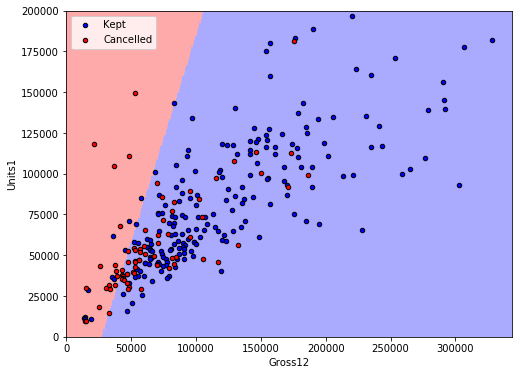

In [6]:
features = ['Gross12', 'Units1']
clf = svm.SVC(kernel='linear', C=100)

plt.figure(figsize=(8,6))
plotClassification2D(df, features, ['Kept', 'Cancelled'], clf)
plt.ylim([0, 200000])
plt.show()

## SVM Disccusion

The Support Vector Machines are not a good classifier in this instance. There's too much overlap between the datasets making it computationally hard to calculate the separating line using support vectors. While the accuracy score was decent, it hid the fact that most of the "Cancelled" items were falsely classified and was thus not a good classifier.

## 5.3 Quadratic Discriminant Analysis (QDA)

There are multiple models that model the data with Gaussian distributions in order to determine the likelihood they are in either class. The most common are Gaussian Naive Bayes classifiers but they assume that each feature is not correlated with the others, and our dataset is highly correlated with one another. 

With Linear Discriminant Analysis, the samples are assumed to have the same covariance. That may not be as bad of an assumption for many of our features, but Quadratic Discriminant Analysis does not make that assumption so we'll start with that.

### Cross-Validation Accuracy

The cross-validated accuracy is much worse than the other classifiers.

In [14]:
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'UI', 'GI', 'Kept', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
scores = cross_val_score(clf,X,y, cv=10)
print("Cross-Validation Score: {}\u00B1{:.0%}\n".format(int(100*scores.mean()), scores.std()))

Cross-Validation Score: 55±12%



### Confusion Matrix

It also has trouble correctly labelling the "cancelled" titles like the other classifiers but also has trouble classifying the "kept" titles.

There also appears to be a fair amount of over-fitting with the training accuracy significantly better than the testing accuracy.

In [15]:
# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

print("Training Accuracy: {:.1%}".format(accuracy_score(y_train, clf.predict(X_train))))
print("Testing Accuracy: {:.1%}".format(accuracy_score(y_test, clf.predict(X_test))))

# Confusion matrix for the test data
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

# Classification report for the testing data set
print('\nClassification Report')
print(classification_report(y_act, y_pred)) 

Training Accuracy: 69.9%
Testing Accuracy: 50.0%

Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,10,8,18
Kept,28,26,54
All,38,34,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.26      0.56      0.36        18
       Kept       0.76      0.48      0.59        54

avg / total       0.64      0.50      0.53        72



### QDA: Plot 2D

Using only two features, we see that QDA overestimates the number of "cancelled" which is what decreases its accuracy when classifying the "kept" titles.  We also see how the "Cancelled" titles fit into an oval shape due to the Gaussian nature of the classifier.

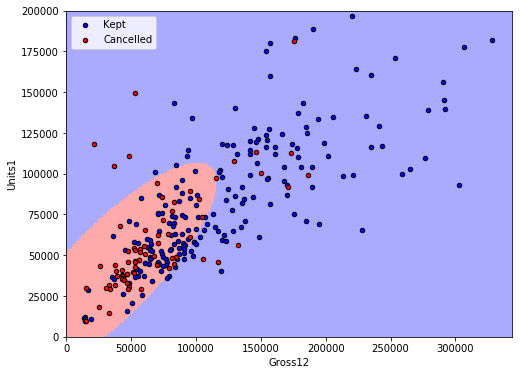

In [13]:
features = ['Gross12', 'Units1']
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()

plt.figure(figsize=(8,6))
plotClassification2D(df, features, ['Kept', 'Cancelled'], clf)
plt.ylim([0, 200000])
plt.show()

## QDA Discussion

The QDA classifier is significantly worse than the other classifiers in pretty much every way. It overfits the data and has poor accuracy with both the "Kept" and "Cancelled" data.

# 6 Conclusion and Future Work

Based on the analysis of multiple classifiers, decision trees make the most sense when it comes to classifying whether titles are kept or cancelled 12 months after debuting. The decision trees are easier to interpret and give comparable accuracy scores compared with other types of classifiers.

From our analysis, we determine that the main factor determining whether a title gets cancelled is whether it has gross sales of around \$60,000 per issue. That may seem like a lot. However, most of the [money in comics](http://www.jimzub.com/the-reality-of-mainstream-creator-owned-comics/) goes to the comic book stores (~50\%), distributors (~15\%), and printers (~\25\%). Only about 10\% of the gross funds actually end up paying the creative team.

That means that \$6000 per issue needs to pay for the author, artist, colorer, letterer, cover artists and the editors assigned to it. Adn that doesn't include overhead (HR, offices, etc.). Even if each person is involved in 2-4 books simultaneously (which is common among established cartoonist), that \$6000 would be near the cost of the comic. 

However, sales alone only accounts for about 75-80\% of cancellations. We've seen that a number of low selling books manage to continue despite their low sales.

In [19]:
print("Kept Titles with Low Sales")
display(df.loc[(df.Kept==1), ['Title', 'Gross12']].sort_values(by='Gross12', ascending=True).head())

Kept Titles with Low Sales


,Title,Gross12
index,,
284,Marvel Adventures Hulk,14094.86
283,Marvel Adventures Iron Man,14546.35
287,Spider-Man,14845.35
286,Marvel Universe Ultimate Spider-Man,14884.22
278,X-Men Manga,16911.44


Most of these low selling books that stick around are geared towards younger readers (either teens or children.) Presumably, these are the readers that are most likely to get their books in collections or digitally rather than going to the comic book store monthly.

This is well known with comics such as *Moon Girl and Devil Dinosaur* which continue to have low monthly sales at comic book stores and yet are commonly attributed to having high sales at Scholastic Book Fair so much so that is will soon be getting a [TV adaption](https://www.dailydot.com/parsec/moon-girl-devil-dinosaur-tv-series/). 

## Future Work

At this point, to improve the accuracy of my classifier it is probably less important to test out other machine learning methods than it would be to increase the variety of sources of my data especially since most of my features are heavily correlated with one another and aren't bringing in new information. That would include trying to estimate digital and comic book trade sales, but it could also mean getting data from other sources.

When *Kanan* was cancelled its sales were especially high, but [pundits](https://dorksideoftheforce.com/2015/12/17/marvels-kanan-comic-series-will-end-with-issue-12/) suggest that it was considered underperforming when compared with other Star Wars comics. This would suggest that a better classifier should take into account the average sales of its comic book family.

Meanwhile, othere titles like *Iceman* which prematurely with 11 issues have gotten renewed after the fact. The [author attributed](https://www.marvel.com/articles/comics/back-by-popular-demand-iceman-returns-this-september) a glowing [New York Times review](https://www.nytimes.com/2018/02/19/books/review/marvel-x-men-iceman-gay.html) as when "people took notice" of the series. This may also have been a series that did well in collected form rather than in monthly sales, but its return is certainly influenced by the buzz surrounding that NYT review. Methods to assess the buzzworhiness of a comic might also influence later sales and the likelihood for a book to get cancelled.

My data was also limited because I had to make a lot of assumptions about what book should be classified as "cancelled". Many titles get cancelled on more than just their 12th issue. Being able to sort through what titles are limited run mini-series and which ones were actually cancelled could also yield more insight.

## Diversity and Sales

In terms of cancellations, I did not see any sign that diveristy in a comic was used as a cancellation factor. However, to better assess that, I would need a way to assign a feature as to whether a book contains a diverse cast or not. However, we've already seen two cases (*Moon Girl* and *Iceman*) where having a non-standard lead character didn't mean that the book did not have an audience, but rather that the audience just simply was not the standard Wednesday warrior who frequents comic book stores. As such, having more sales information beyond monthy issue sales may be necessary to determine whether those books will continue.